In [1]:
import grmpy
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pylab import rcParams
from linearmodels.iv import IV2SLS

from sources.auxiliary import plot_joint_distribution_unobservables
from sources.auxiliary import plot_joint_distribution_outcomes
from sources.auxiliary import plot_benefits_and_effects
from sources.auxiliary import investigate_mte
from sources.auxiliary import plot_estimates
from sources.auxiliary import plot_effects
from sources.auxiliary import monte_carlo

rcParams["figure.figsize"] = 12, 8
rcParams["font.size"] = 20

# Generalized Roy Model

_In this problem set, we are going to make use of the open-source Python package [grmpy](https://github.com/OpenSourceEconomics/grmpy) to gain a practical understanding of the generalized Roy model and the economics behind it. We will employ [grmpy](https://github.com/OpenSourceEconomics/grmpy) for both simulation and estimation purposes and, in particular, estimate *marginal treatment effects (MTE)*. To become familiar with the capabilities of [grmpy](https://github.com/OpenSourceEconomics/grmpy), we will explore the relationship between college education and income using a toy data set in Task A. In Task B, we will then conduct a Monte Carlo analysis using our own simulated data. Auxiliary functions for Task B are provided in the file [auxiliary.py](https://github.com/HumanCapitalAnalysis/microeconometrics/blob/master/problem-sets/generalized-roy-model/sources/auxiliary.py)._

## TASK A

_Suppose we want to estimate the effect of post-secondary education on income. We use a toy model where log earnings *(Y)* is a function of experience *(exp)*, experience squared *(expsq)*, and mother’s education (*momsEdu*). The decision to enroll in college *(D)* is modeled as a function of mother’s education and distance to college *(distCol)*._

In this task, you'll learn how to:
- import and export data files in the *pickle* format 
- analyze *pandas* DataFrames
- create basic plots with *seaborn*
- use *grmpy* to estimate and plot *Marginal Treatmen Effects* (*MTE*)

**Resources**:
- Reading *pickle* files with *pandas*: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_pickle.html

- Saving *pickle* files with *pandas*: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_pickle.html#pandas.DataFrame.to_pickle

- Plotting with *seaborn*:
https://seaborn.pydata.org/tutorial/distributions.html

- Dealing with NaNs in *pandas* DataFrames: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

- *grmpy* Documentation: https://grmpy.readthedocs.io/en/latest/tutorial.html

## 1) Data Cleaning

### Import Raw Data

| variable | meaning |
| -------- | ------- |
| wage | logarithm of hourly wages |
| enroll   |               =1 if attended college |
| exp |               years of labor market experience |
| exp2    |           labor market experience squared |
| momsEdu |               mother's years of schooling |
| distCol |              distance to nearest college (in km)|

In [2]:
data = pd.read_pickle("data/education_data_raw.pkl")

In [3]:
data.head()

,wage,enroll,exp,exp2,momsEdu,distCol
0,1.750761,1.0,12.333383,152.112320,10.798113,3.131401
1,4.846447,1.0,29.095451,846.545288,10.066148,11.846854
2,2.884425,1.0,9.877062,97.556351,11.661082,16.798515
3,2.639430,0.0,4.523223,20.459551,14.799751,25.666601
4,2.303309,1.0,17.394547,302.570251,13.996597,36.076962


### Drop Missing Values

In [4]:
data = data.dropna()

### Plot Wage Distribution

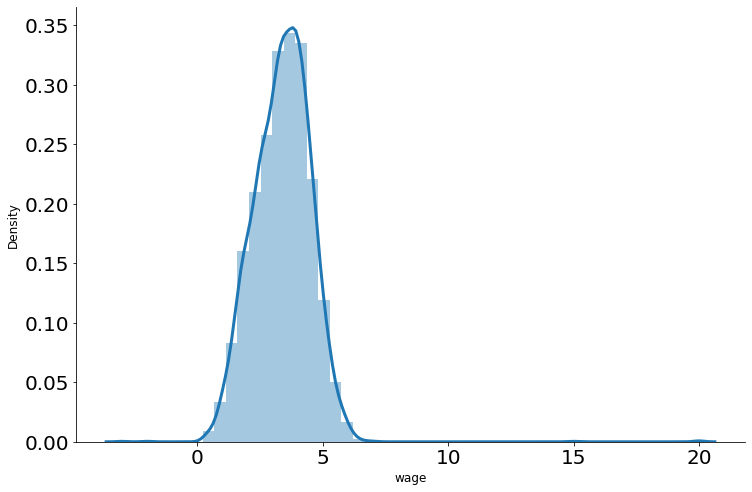

In [5]:
sns.distplot(data["wage"])
plt.show()

### Detect and Delete Outliers

In [6]:
data.loc[data["wage"] < 0]

,wage,enroll,exp,exp2,momsEdu,distCol
100,-2.0,0.0,6.143672,37.744705,14.653296,40.399162
1307,-3.0,0.0,26.190847,685.960510,8.856008,24.471748


In [7]:
data.loc[data["wage"] > 10]

,wage,enroll,exp,exp2,momsEdu,distCol
2020,20.0,0.0,14.677003,215.414413,15.791445,9.648646
3750,20.0,1.0,20.448292,418.132629,13.125582,25.551018
4111,15.0,0.0,37.680630,1419.829834,10.269114,35.957970


In [8]:
data_clean = data[(data.wage >= 0) & (data.wage <= 10)]

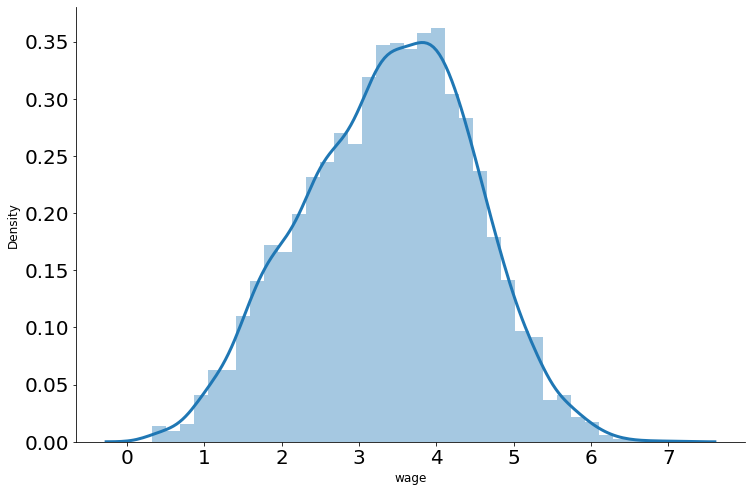

In [9]:
# Check if cleaning successful
sns.distplot(data_clean["wage"])
plt.show()

### Save Clean Data Set as New *pkl* File

In [10]:
data_clean.to_pickle("data/education_data_clean.pkl")

## 2) Update initialization (**.yml*) file

There are two ways to do this:
- Open a text editor and type *data/education_data_clean.pkl* in the blank after *ESTIMATION file:* <br>
  Then restart the kernel.
- Change the cell below from *markdown* to *code* and run it. <br>
  (I copied and pasted the contents of the original initialization file into the cell below and included the correct file path. Running it will overwrite the initialization file directly. You do not need to restart your kernel.)

%%file sources/education.grmpy.yml
---
ESTIMATION:
    file: data/education_data_clean.pkl
    dependent: wage
    indicator: enroll
        
    # parametric model
    output_file: est.grmpy.info
    optimizer: SCIPY-BFGS
    start: auto
    maxiter: 6383
    agents: 165
    comparison: True
    print_output: False
    
    # semiparametric model
    show_output: False
    logit: True
    nbins: 30
    rbandwidth: 0.05
    bandwidth: 0.3
    gridsize: 500
    ps_range: [0.005, 0.995]
TREATED:
    order:
    - exp
    - exp2
    - momsEdu
UNTREATED:
    order:
    - exp
    - exp2
    - momsEdu
CHOICE:
    order:
    - momsEdu
    - distCol
DIST:
    params:
    - 0.1
    - 0.0
    - 0.0
    - 0.1
    - 0.0
    - 1.0
SCIPY-BFGS:
    gtol: 1.0e-05
    eps: 1.4901161193847655e-08
SCIPY-POWELL:
    xtol: 9.147777614048603e-05
    ftol: 9.749582129043358e-05

## 3) Estimation

### Fit the Parametric Model and Plot the *MTE*

*Note*: The parametric normal model (semipar=False) is set by default.

In [11]:
rslt_par = grmpy.fit("sources/education.grmpy.yml", semipar=False)

                              Optimization Results
Dep. Variable:                 wage     Optimizer:                          BFGS
Choice Var:                  enroll     No. Evaluations:                      43
Date:              Wed, 14 Apr 2021     Success:                               1
Time:                      20:15:27     Status:                                0
Observations:                  4848     Message:         Optimization terminated
Start Values:                  auto                                successfully.
                                        Criterion Func:                         
                                             Start:                      +1.3705
                                             Finish:                     +1.3028
                        coef   std err         t     P>|t|     [0.025     0.975]
--------------------------------------------------------------------------------
TREATED       

const                 0.2109     0.077    

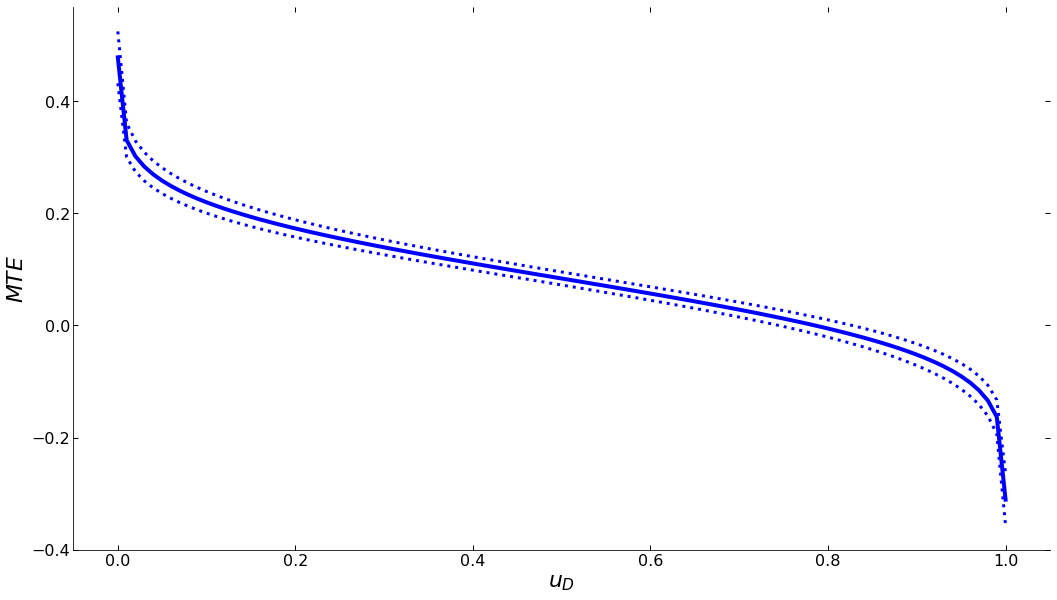

In [12]:
grmpy.plot_mte(rslt_par, "sources/education.grmpy.yml", semipar=False)

### Fit the Semiparametric Model and Plot the *MTE*

**Remarks**: 
- The standard errors and corresponding confidence intervals for the semiparametric *MTE* are bootstrapped (as opposed to the parametric *MTE*, where confidence intervals are computed analytically). Here, when plotting the seimparametric *MTE*, specifiy 250 bootstrap iterations.
- Choose a different color for the semiparmateric *MTE* than you did in **7)** and save the plot

In [13]:
rslt_semipar = grmpy.fit("sources/education.grmpy.yml", semipar=True)

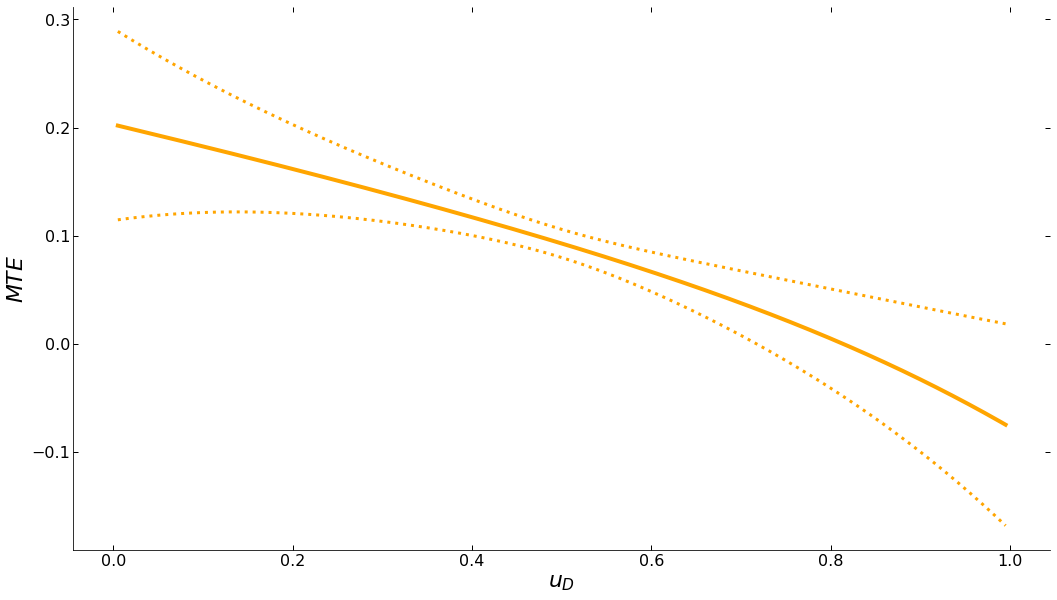

In [14]:
grmpy.plot_mte(
    rslt_semipar,
    "sources/education.grmpy.yml",
    semipar=True,
    nboot=250,
    color="orange",
    save_plot="MTE_semipar.png",
)

## TASK B

_To gain more insights into the economic implications behind grmpy and the realm of marginal treatment effects, you will now perform a simulated Monte Carlo analysis. Sim- ulated data allows us to explore additional objects of interest, for which we are not able to obtain reliable information using empirical data sets. With simulated data, we have information on the whole range of potential outcomes for each individual and can bypass the evaluation problem. Moreover, we can directly construct conventional treatment effect parameters on the population level (e.g. see chapters 2.3, 2.4, and 3.3 in [Heckman & Vytlacil (2007a))](https://www.sciencedirect.com/science/article/pii/S1573441207060709)._

_We will stick with our college example from above. For simplicity, however, assume now that log earnings (Y) only depend on mother’s education (momsEdu), and the enrollment decision is solely driven by distance to college (distCol). To help you along with the analysis, we have prepared some auxiliary functions in [auxiliary.py](https://github.com/HumanCapitalAnalysis/microeconometrics/blob/master/problem-sets/generalized-roy-model/sources/auxiliary.py)._

## 1) Simulate Data Set without Essential Heterogeneity

In [15]:
data = grmpy.simulate("sources/sim.grmpy.yml")
data.head()

,const,momsEdu,distCol,U1,U0,V,Y1,Y0,D,Y
0,1.0,-0.225034,1.012175,0.052736,0.036747,0.410380,0.927842,0.480489,0.0,0.480489
1,1.0,-0.405429,0.016576,0.167313,0.084724,-1.789534,0.942300,0.483366,1.0,0.942300
2,1.0,-0.590194,-0.010326,0.077226,0.009501,-1.420377,0.749669,0.361952,1.0,0.749669
3,1.0,-0.036321,-0.196745,-0.013412,-0.025191,0.052811,0.966430,0.465729,1.0,0.966430
4,1.0,0.049373,-0.534595,0.053207,-0.278110,-0.043756,1.080609,0.234233,1.0,1.080609


Joint distribution of potential outcomes

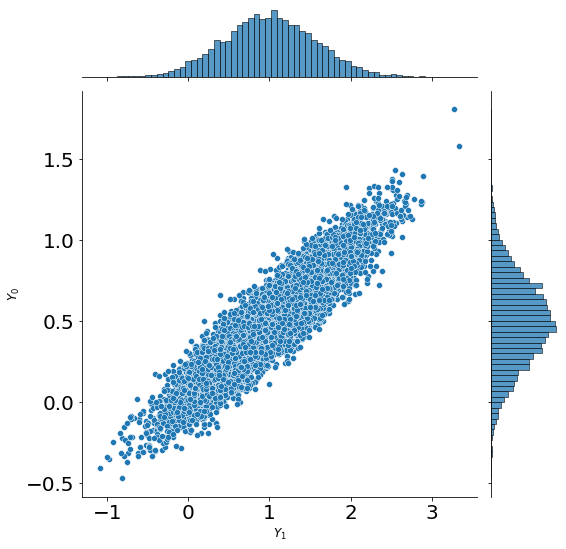

In [16]:
plot_joint_distribution_outcomes(data)

## 2) Compute Conventional Average Treatment Effect Parameters

In [17]:
treated = data["D"] == 1
untreated = data["D"] == 0

ATE = np.mean(data["Y1"] - data["Y0"])
TT = np.mean(data["Y1"].loc[treated] - data["Y0"].loc[treated])
TUT = np.mean(data["Y1"].loc[untreated] - data["Y0"].loc[untreated])

fmt = "ATE: {}\nTT:  {}\nTUT: {} \n"
print(fmt.format(ATE, TT, TUT))

ATE: 0.49837010112785857
TT:  0.4954024417207537
TUT: 0.5035665666371357 



## 3) Plot Distribution of Benefits

ATE: 0.49837010112785857
TT:  0.4954024417207537
TUT: 0.5035665666371357 



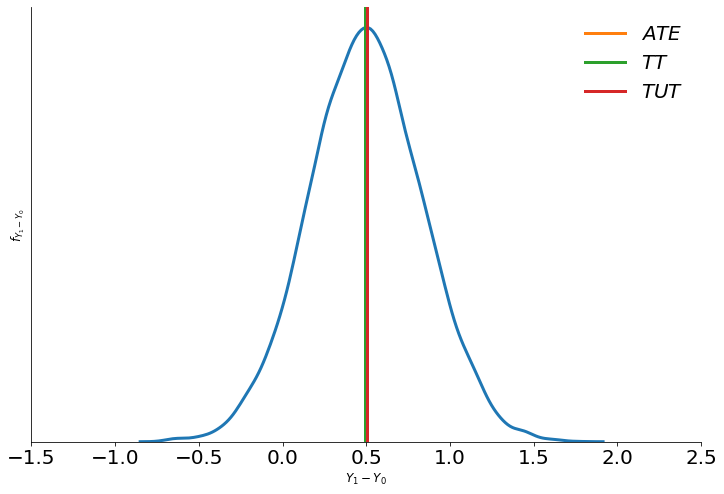

In [18]:
plot_benefits_and_effects(data)

## 4) Simulate Data Set with Essential Heterogeneity

In [19]:
data_eh = grmpy.simulate("sources/sim-eh.grmpy.yml")
data_eh.head()

,const,momsEdu,distCol,U1,U0,V,Y1,Y0,D,Y
0,1.0,-0.225034,1.012175,-0.047684,0.059403,0.407904,0.827422,0.503145,0.0,0.503145
1,1.0,-0.405429,0.016576,-0.000332,0.091776,-1.797355,0.774655,0.490419,1.0,0.774655
2,1.0,-0.590194,-0.010326,0.019922,0.002064,-1.423980,0.692364,0.354516,1.0,0.692364
3,1.0,-0.036321,-0.196745,-0.002204,-0.026339,0.053439,0.977638,0.464581,1.0,0.977638
4,1.0,0.049373,-0.534595,-0.144077,-0.241421,-0.046249,0.883324,0.270922,1.0,0.883324


We investigate distribution of the unobservables when essential heterogeneity is absent and present, respectively.

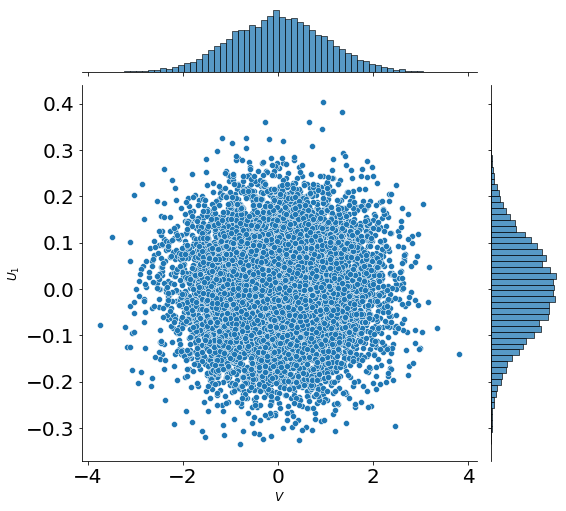

In [20]:
plot_joint_distribution_unobservables(data)

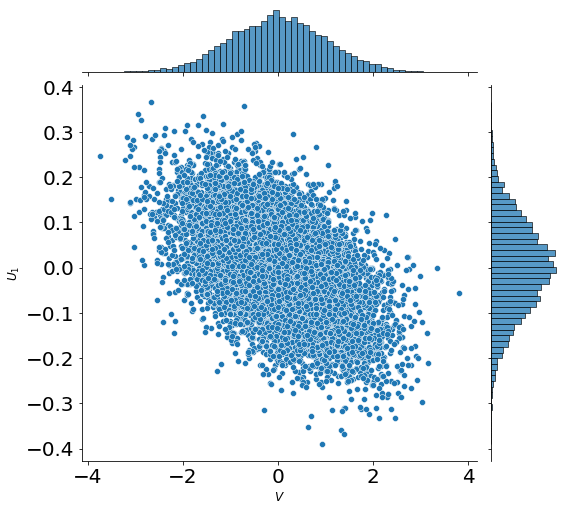

In [21]:
plot_joint_distribution_unobservables(data_eh)

## 5) Compute Conventional Average Treatment Effect Parameters Again

In [22]:
treated = data_eh["D"] == 1
untreated = data_eh["D"] == 0

ATE = np.mean(data_eh["Y1"] - data_eh["Y0"])
TT = np.mean(data_eh["Y1"].loc[treated] - data_eh["Y0"].loc[treated])
TUT = np.mean(data_eh["Y1"].loc[untreated] - data_eh["Y0"].loc[untreated])

fmt = "ATE: {}\nTT:  {}\nTUT: {} \n"
print(fmt.format(ATE, TT, TUT))

ATE: 0.4991197069001682
TT:  0.5395619748560901
TUT: 0.42821211814925686 



ATE: 0.4991197069001682
TT:  0.5395619748560901
TUT: 0.42821211814925686 



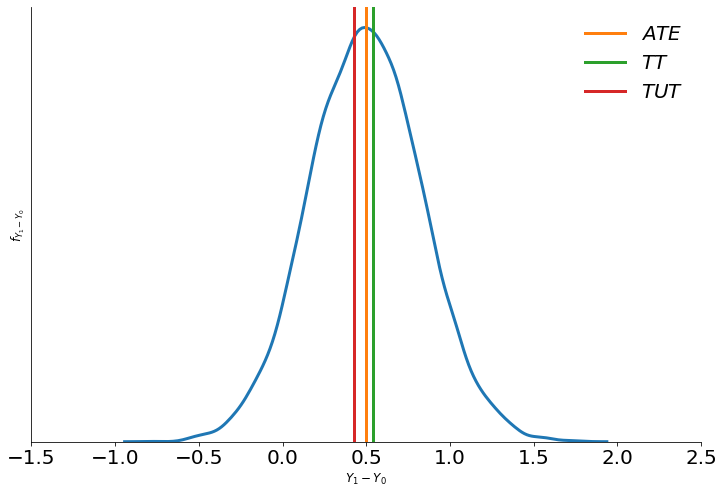

In [23]:
plot_benefits_and_effects(data_eh)

## 6) Investigate Shape of MTE

Let us revisit the shape of the marginal effect of college attendance with and without essential hetergeneity.

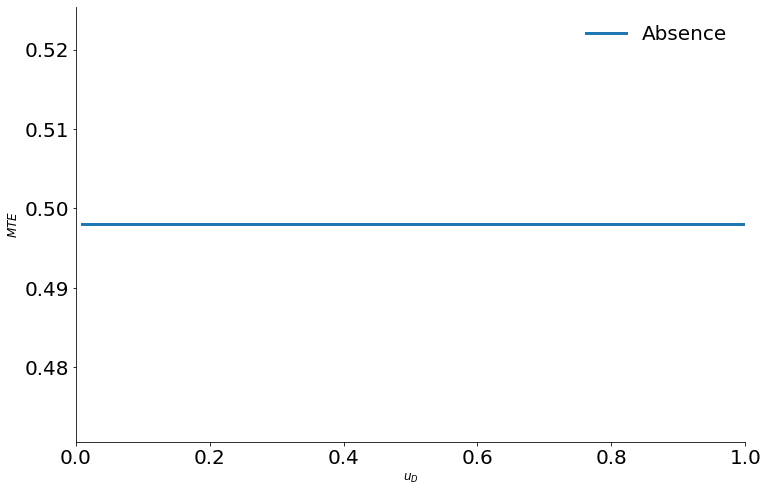

In [24]:
investigate_mte("data.grmpy.info")

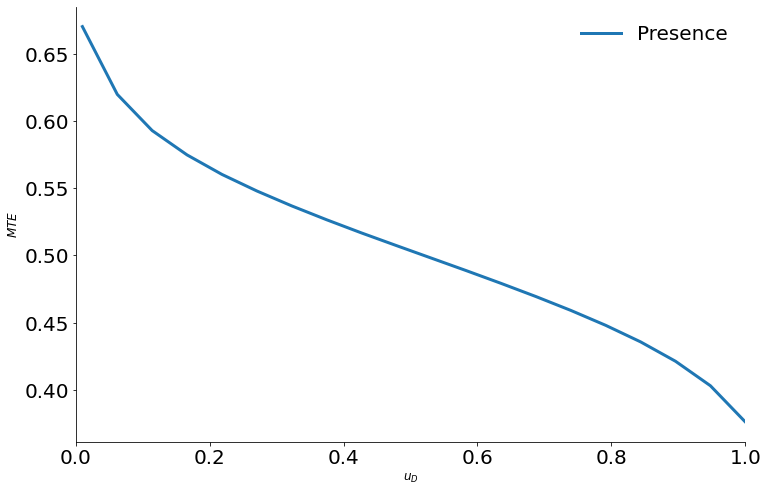

In [25]:
investigate_mte("data_eh.grmpy.info")

## 7) Simulate a new sample for the Monte Carlo exploration

In [26]:
data_mc = grmpy.simulate("sources/mc.grmpy.yml")

How do the ATE and TT diverge if we introduce essential heterogeneity?

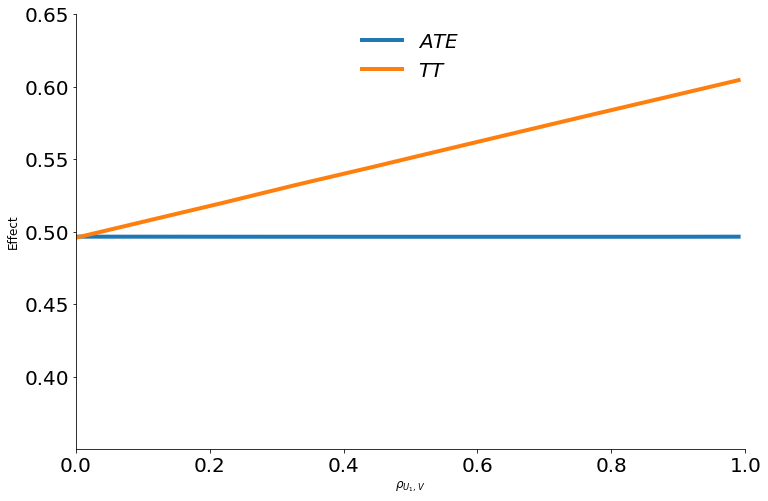

In [27]:
effects = monte_carlo("sources/mc.grmpy.yml", "conventional_average_effects")
plot_effects(effects)

## 8) Estimation of ATEs for Increasing Positive Selection into Treatment

## Estimation Strategies:
- Randomization
- Ordinary Least Squares
- Conventional Instrumental Variables
- grmpy
    - Parametric Normal Model
    - Local Instrumental Variables

## Randomization

Without essential heterogeneity

In [28]:
treated = data_mc["D"] == 1
untreated = data_mc["D"] == 0

ATE = np.mean(data_mc["Y"].loc[treated]) - np.mean(data_mc["Y"].loc[untreated])
print("Effect ", ATE)

Effect  0.4840767869358851


Introducing essential heterogeneity

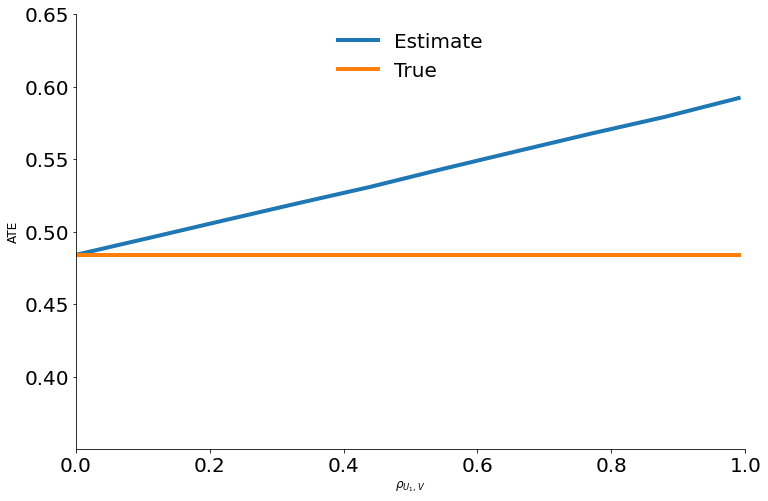

In [29]:
estimate = monte_carlo("sources/mc.grmpy.yml", "randomization")
plot_estimates(ATE, estimate)

## Ordinary Least Squares

We look at an OLS regression in the baseline sample without essential heterogeneity. <br>
The coefficient on the treatment dummy *D* captures the average treatment effect (ATE).

In [30]:
OLSresults = sm.OLS(data_mc["Y"], data_mc[["const", "D"]]).fit()
print(OLSresults.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     2025.
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:16:30   Log-Likelihood:                -7590.9
No. Observations:               10000   AIC:                         1.519e+04
Df Residuals:                    9998   BIC:                         1.520e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5114      0.009     59.516      0.0

Introducing essential heterogeneity

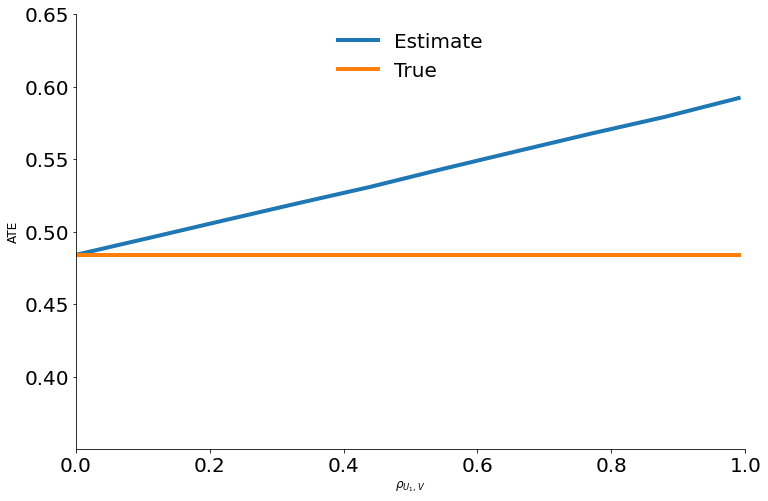

In [31]:
estimate = monte_carlo("sources/mc.grmpy.yml", "ols")
plot_estimates(ATE, estimate)

## Conventional Instrumental Variables 

Without essential heterogeneity

In [32]:
IVresults = IV2SLS(
    data_mc["Y"], data_mc[["const", "momsEdu"]], data_mc["D"], data_mc["distCol"],
).fit()
print(IVresults)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                      0.8060
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8060
No. Observations:               10000   F-statistic:                 2.068e+04
Date:                Wed, Apr 14 2021   P-value (F-stat)                0.0000
Time:                        20:16:34   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.5070     0.0125     40.501     0.0000      0.4824      0.5315
momsEdu        0.4475     0.0032     142.03     0.00

Introducing essential heterogeneity

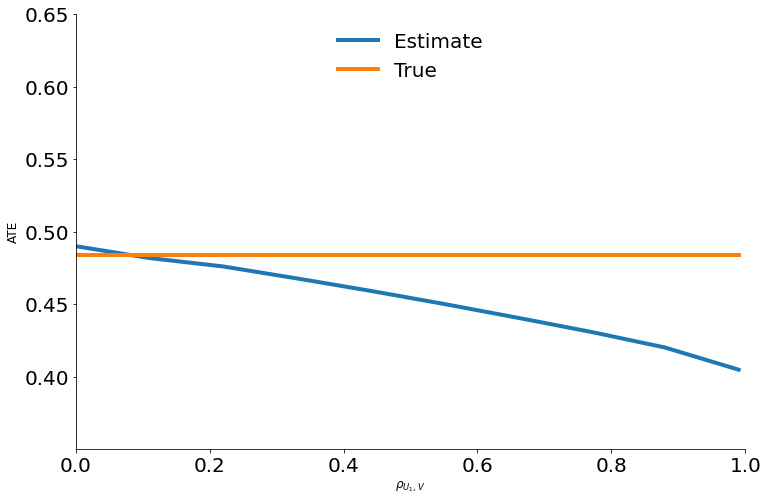

In [33]:
estimate = monte_carlo("sources/mc.grmpy.yml", "iv")
plot_estimates(ATE, estimate)

## *grmpy*

### 1) Parametric Normal Model

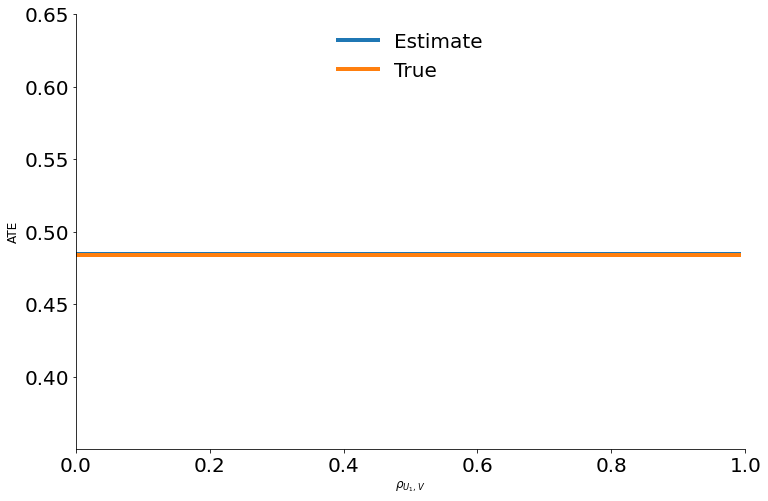

In [34]:
estimate = monte_carlo("sources/mc.grmpy.yml", "grmpy")
plot_estimates(ATE, estimate)

### 2) Local Instrumental Variables

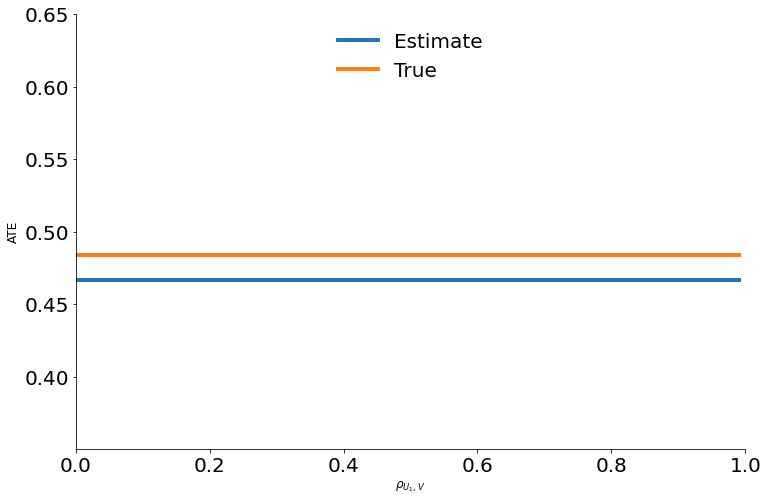

In [35]:
estimate = monte_carlo("sources/mc.grmpy.yml", "grmpy-liv")
plot_estimates(ATE, estimate)

## References

* **grmpy (2018)**. [A Python package for the simulation and estimation of the generalized Roy model.](http://doi.org/10.5281/zenodo.1162639)


* **Heckman, J. J., Urzua, S., & Vytlacil, E. J. (2006)**. [Understanding instrumental variables in models with essential heterogeneity.](https://www.jstor.org/stable/40043006?seq=1) *Review of Economics and Statistics*, 88(3), 389–432.


* **Heckman, J. J., & Vytlacil, E. J. (2007a)**. [Econometric evaluation of social programs, part I: Causal effects, structural models and econometric policy evaluation.](https://www.sciencedirect.com/science/article/pii/S1573441207060709) In J. J. Heckman & E. E. Leamer (Eds.), *Handbook of econometrics*, 6, 4779–4874.


* **Heckman, J. J., & Vytlacil, E. J. (2007b)**. [Econometric evaluation of social programs, part II: Using the marginal treatment effect to organize alternative economic estimators to evaluate social programs and to forecast their effects in new environments.](https://www.sciencedirect.com/science/article/pii/S1573441207060710) In J. J. Heckman & E. E. Leamer (Eds.), *Handbook of econometrics*, 6, 4875-5144.